# Аугментация тренировочных данных

В данном ноутбуке иллюстрируется процесс аугментации тренировочных изображений. Цель этого действия - выровнять распределении изображений по классам.

Основа аугментации - четыри действия:
* Центральное увеличение
* Горизонтальное отражение
* Изменение насыщенности
* Изменение контраста

Центральному увеличению подвергаются все изображения проходящие через процесс аугментации, а остальные действия применяются рандомно.

In [ ]:
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from numpy.random import randint
import tensorflow as tf
import matplotlib.pyplot as plt
import gdown
import os

In [ ]:
#  Загружаем, распаковываем, удаляем train.zip.
if not os.path.exists('train'):
    if not os.path.exists('train.zip'):
        train_zip_url = 'https://drive.google.com/uc?id=1QdhIxh1QUEuLgRb7DWa7RA7CA08ybNRJ'
        gdown.download(train_zip_url, 'train.zip', False)
    ! unzip train.zip -d .
    ! rm train.zip

In [ ]:
class Augmentation():

    def __init__(self, train_dir, target_dir = None):
        self.train_dir = train_dir
        self.target_dir = target_dir
        (self.max_num, self.max_cl) = self.max_distrib()
        self.classes = self.class_list()
        self.classes.remove(self.max_cl)
        self.classes = {cl:(f'{train_dir}/{cl}',self.num_class_elem(cl)) for cl in self.classes}

    def augment(self):
        print('Augmentating...:')
        for cl_name, item in tqdm(self.classes.items()):
            path_class = item[0]
            num_elem_class = item[1]
            print(cl_name)
            for id_img in tqdm(range(self.max_num - num_elem_class)): 
                if id_img >= num_elem_class:
                    id_img -= num_elem_class
                    img = self.take_image_from_class(cl_name, id_img)
                    img = self.create_aug_img(img)
                    id_img = 'new' + str(id_img)
                    self.save(img, id_img, cl_name)
                else:
                    img = self.take_image_from_class(cl_name, id_img)
                    img = self.create_aug_img(img)
                    self.save(img, str(id_img), cl_name)

    def take_image_from_class(self, cl_name, id_img):
        img = Image.open(f'{self.classes[cl_name][0]}/{str(id_img)}.jpg')
        return np.array(img)
    
    def create_aug_img(self, img):
        pipline = randint(1,3)
        img = tf.image.central_crop(img, central_fraction=0.7)
        if pipline == 1:
            img = tf.image.flip_left_right(img)
        elif pipline == 2:
            img = tf.image.adjust_saturation(img, 1.2)
        else:
            img = tf.image.adjust_contrast(img,2)
        return img.numpy()

    def save(self, img, num_img, cl):
        img = Image.fromarray(img)
        img.save(self.target_dir + '/' + cl + '/aug' + num_img + '.jpg')

    def num_class_elem(self, cl):
        cl_path = f'{self.train_dir}/{cl}'
        num = ! ls $cl_path | wc -l
        return int(num[0])

    def max_distrib(self):
        ls = []
        for cl in self.class_list():
            cl_path = f'{self.train_dir}/{cl}' # формируем путь к классу
            res = ! ls $cl_path | wc -l # определение количества элементов в классе
            ls.append((int(res[0]), cl))
        return max(ls)
        
    def class_list(self):
        res = ! ls $self.train_dir
        return res[0].split()

In [ ]:
a = Augmentation(train_dir = 'train', target_dir ='train')

In [ ]:
a.classes

{'contempt': ('train/contempt', 3085),
 'disgust': ('train/disgust', 3155),
 'fear': ('train/fear', 5044),
 'happy': ('train/happy', 5955),
 'neutral': ('train/neutral', 6795),
 'sad': ('train/sad', 6740),
 'surprise': ('train/surprise', 6323),
 'uncertain': ('train/uncertain', 5927)}

In [ ]:
%%time
# Замер без GPU
a.augment()

Augmentating...:


contempt



disgust



fear



happy



neutral



sad



surprise



uncertain




CPU times: user 5min 26s, sys: 17.1 s, total: 5min 43s
Wall time: 5min 18s


In [ ]:
! ls train/contempt | wc -l
! ls train/happy | wc -l
! ls train/anger | wc -l
! ls train/disgust | wc -l
! ls train/fear | wc -l
! ls train/sad | wc -l
! ls train/uncertain | wc -l
! ls train/surprise | wc -l
! ls train/neutral | wc -l
#  Видно, что теперь все классы "подтянулись" к самому многочисленному.

7022
7022
7022
7022
7022
7022
7022
7022
7022


In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(Image.open(original))

    
  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(Image.open(augmented))

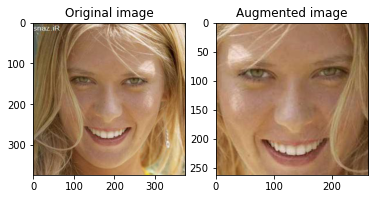

In [ ]:
visualize(original='train/happy/0.jpg',augmented='train/happy/aug0.jpg')
# Пример аугментированного изобаржения (в данном случае произошло центральное увеличение и горизонтальное отражение)